In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os


DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/Sen1Floods11/flood_data"
HL_ROOT   = f"{DATA_ROOT}/HandLabeled"       # HandLabeled subset
WL_ROOT   = f"{DATA_ROOT}/WeaklyLabeled"     # WeaklyLabeled subset

S1_HAND   = f"{HL_ROOT}/S1Hand"
LAB_HAND  = f"{HL_ROOT}/LabelHand"
S2_HAND   = f"{HL_ROOT}/S2Hand"
OTS_HAND  = f"{HL_ROOT}/S1OtsuLabelHand"

for p in [DATA_ROOT, HL_ROOT, WL_ROOT]:
    os.makedirs(p, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)


DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/Sen1Floods11/flood_data


In [ ]:
# authenticate once per session
!gcloud auth login --quiet

# list to confirm path exists
!gsutil ls gs://sen1floods11/v1.1/data/flood_events/HandLabeled/

# sync the small ~1.8GB “gold” subset
!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled "$HL_ROOT"

# quick check
!ls -l "$HL_ROOT" | sed -n '1,200p'

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=NymDOJJIYy2oPhzFvuIY8xqxouPNLw&prompt=consent&token_usage=remote&access_type=offline&code_challenge=raZp05WsGfXsZEMRtKs7QK4F-hUXDQtPm519rAFh0hg&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 

Command killed by keyboard interrupt

^C
gs://sen1floods11/v1.1/data/flood_events/HandLabeled/JRCWaterHand/
gs://sen1floods11/v1.1/data/flood_ev

In [ ]:
import glob
def count(pattern): return len(glob.glob(pattern))
print("S1Hand  :", count(f"{S1_HAND}/*.tif"))
print("LabelHand:", count(f"{LAB_HAND}/*.tif"))
print("S2Hand  :", count(f"{S2_HAND}/*.tif"))
print("OtsuHand:", count(f"{OTS_HAND}/*.tif"))

S1Hand  : 446
LabelHand: 446
S2Hand  : 446
OtsuHand: 446


| file                                | purpose                          |
| ----------------------------------- | -------------------------------- |
| `Mekong_221789_S1Hand.tif`          | Sentinel-1 radar (VV + VH) input |
| `Mekong_221789_LabelHand.tif`       | human water mask (0/1)           |
| `Mekong_221789_S2Hand.tif`          | Sentinel-2 optical image         |
| `Mekong_221789_S1OtsuLabelHand.tif` | auto-threshold water mask        |
| `Mekong_221789_JRCWaterHand.tif`    | permanent water reference        |
so each region has 5 files with matching prefixes → 446 regions × 5 = 2230 files total.

In [ ]:
def validate_mask(mask, auto_flip=False, name="mask"):
    """
    Validate a Sen1Floods11 label mask before visualization.

    Parameters
    ----------
    mask : np.ndarray
        The 2D binary flood mask (0=land, 1=water).
    auto_flip : bool, optional
        If True, automatically invert masks that look reversed (>98% water).
    name : str, optional
        Optional label for printing context.

    Returns
    -------
    mask : np.ndarray
        Possibly flipped mask if auto_flip=True.
    valid : bool
        Whether the mask appears valid for visualization.
    """
    vals, counts = np.unique(mask, return_counts=True)
    frac_ones = counts[vals == 1].sum() / mask.size if 1 in vals else 0
    frac_zeros = counts[vals == 0].sum() / mask.size if 0 in vals else 0

    # Handle edge cases
    if len(vals) == 1:
        print(f"⚠️ [{name}] Constant mask ({int(vals[0])}) — skipping.")
        return mask, False
    if np.isnan(mask).all():
        print(f"⚠️ [{name}] All NaN — skipping.")
        return mask, False
    if frac_ones > 0.98:
        msg = f"⚠️ [{name}] {frac_ones*100:.1f}% water — likely inverted or corrupted."
        if auto_flip:
            print(msg + " → Flipping mask automatically.")
            mask = 1 - mask
            return mask, True
        else:
            print(msg)
            return mask, False
    if frac_ones < 0.01:
        print(f"⚠️ [{name}] {frac_ones*100:.2f}% water — almost no flooded pixels.")
        return mask, False

    print(f"✅ [{name}] Looks valid — {frac_ones*100:.1f}% water, {frac_zeros*100:.1f}% land.")
    return mask, True

## Visualize a random tile from S1Hand

In [ ]:
import rasterio, numpy as np, matplotlib.pyplot as plt, glob, os, random
from matplotlib.colors import ListedColormap

def visualize_S1Hand_tile(S1_HAND, LAB_HAND, auto_flip=False, show_nodata=False):
    """
    Visualize a random Sentinel-1 hand-labeled tile from Sen1Floods11.
    Handles 3-class masks per catalog spec: -1=NoData, 0=Land, 1=Water.

    Parameters
    ----------
    S1_HAND : str
        Path to folder containing Sentinel-1 hand-labeled TIFFs.
    LAB_HAND : str
        Path to folder containing corresponding label TIFFs.
    auto_flip : bool, optional
        Whether to auto-flip near-constant water masks (from validate_mask).
    show_nodata : bool, optional
        If True, display NoData (-1) pixels in gray instead of treating as land.
    """

    # --- Select random file pair ---
    s1_files = sorted(glob.glob(f"{S1_HAND}/*.tif"))
    s1_path = random.choice(s1_files)
    prefix = os.path.basename(s1_path).replace("_S1Hand.tif", "")
    label_path = f"{LAB_HAND}/{prefix}_LabelHand.tif"

    print(f"\nSelected prefix: {prefix}")
    print(f"S1 file: {os.path.basename(s1_path)}")
    print(f"Label file: {os.path.basename(label_path)}")

    # --- Load Sentinel-1 (VV/VH) ---
    with rasterio.open(s1_path) as src:
        s1 = src.read()        # (2,H,W)
        meta = (src.count, src.descriptions, src.width, src.height, src.dtypes)
    with rasterio.open(label_path) as src:
        raw_mask = src.read(1)  # (H,W), values in {-1,0,1}

    print("S1 bands / desc / shape / dtype:", meta)
    vv, vh = s1[0], s1[1]

    # --- Clean mask ---
    mask = np.nan_to_num(raw_mask)
    nodata_mask = (mask == -1)
    mask[mask < 0] = 0         # convert NoData → 0 for validation/training
    mask = (mask == 1).astype(np.uint8)  # binary 0/1 for display

    # --- Validate mask ---
    mask, valid = validate_mask(mask, auto_flip=auto_flip, name=os.path.basename(label_path))
    if not valid:
        print("Skipping visualization (invalid mask).")
        return

    # --- Normalize radar bands ---
    def norm(a):
        a = np.nan_to_num(a)
        vmin, vmax = np.nanmin(a), np.nanmax(a)
        if vmax - vmin < 1e-6:
            return np.zeros_like(a)
        return (a - vmin) / (vmax - vmin)
    vvn, vhn = norm(vv), norm(vh)

    # --- Overlay: highlight only water ---
    overlay = np.zeros((*mask.shape, 4))
    overlay[mask == 1] = [0.8, 0.1, 0.1, 0.5]  # red semi-transparent

    # --- Colormap for mask-only panel ---
    if show_nodata:
        # 0=land, 1=water, -1=gray (from raw mask)
        mask_display = np.full_like(mask, 0, dtype=np.uint8)
        mask_display[nodata_mask] = 2
        mask_display[mask == 1] = 1
        cmap = ListedColormap(["white", "red", "gray"])  # land, water, nodata
    else:
        cmap = ListedColormap(["white", "red"])

    # --- Plot ---
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    plt.suptitle(f"HandLabeled — Sentinel-1 (VV/VH) and Water Mask\n{prefix}", y=1.08, fontsize=12)

    ax[0].imshow(vvn, cmap='gray'); ax[0].set_title("S1 VV")
    ax[1].imshow(vhn, cmap='gray'); ax[1].set_title("S1 VH")
    ax[2].imshow(mask if not show_nodata else mask_display, cmap=cmap)
    ax[2].set_title("Label (water mask)")
    ax[3].imshow(vvn, cmap='gray')
    ax[3].imshow(overlay)
    ax[3].set_title("VV + Water Mask Overlay")

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()



Selected prefix: Paraguay_1029042
S1 file: Paraguay_1029042_S1Hand.tif
Label file: Paraguay_1029042_LabelHand.tif
S1 bands / desc / shape / dtype: (2, ('VV', 'VH'), 512, 512, ('float32', 'float32'))
✅ [Paraguay_1029042_LabelHand.tif] Looks valid — 23.3% water, 76.7% land.


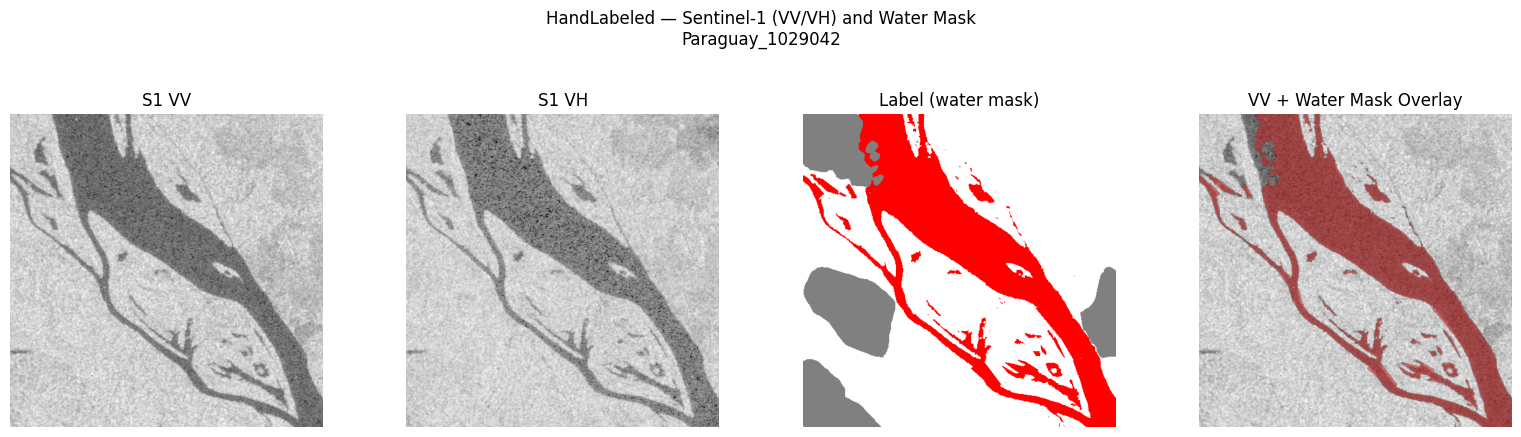

In [ ]:
visualize_S1Hand_tile(S1_HAND, LAB_HAND, auto_flip=True,show_nodata=True)


| Panel                  | What it shows                                                                                                                                                                                                 |
| ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **S1 VV / S1 VH**      | Two polarizations of Sentinel-1 radar backscatter. Brighter = stronger radar reflection (urban areas, rough ground, or slopes facing the radar). Darker = smoother surfaces, often open water or flat fields. |
| **Label (water mask)** | The binary ground-truth water map (dark red = labeled as water, pale background = land).                                                                                                                      |
| **Overlay**            | The VV backscatter image with the red mask semi-transparent on top — showing where the “water” pixels fall relative to the radar intensity.                                                                   |


## Otsu vs Hand label


In [ ]:
import rasterio, numpy as np, matplotlib.pyplot as plt, glob, os, random
from matplotlib.colors import ListedColormap

def visualize_S1Hand_and_Otsu_side_by_side(S1_HAND, LAB_HAND, OTSU_HAND, auto_flip=False):
    """
    Visualize a Sentinel-1 tile with both Hand-labeled and Otsu-labeled masks side by side.

    Parameters
    ----------
    S1_HAND : str
        Path to folder containing Sentinel-1 hand-labeled TIFFs.
    LAB_HAND : str
        Path to folder containing Hand label TIFFs.
    OTSU_HAND : str
        Path to folder containing Otsu label TIFFs.
    auto_flip : bool
        Whether to auto-flip nearly constant masks via validate_mask().
    """

    # --- Random tile selection ---
    s1_files = sorted(glob.glob(f"{S1_HAND}/*.tif"))
    s1_path = random.choice(s1_files)
    prefix = os.path.basename(s1_path).replace("_S1Hand.tif", "")
    hand_path = f"{LAB_HAND}/{prefix}_LabelHand.tif"
    otsu_path = f"{OTSU_HAND}/{prefix}_S1OtsuLabelHand.tif"

    print(f"\nSelected prefix: {prefix}")
    print(f"S1 file:   {os.path.basename(s1_path)}")
    print(f"Hand label:{os.path.basename(hand_path)}")
    print(f"Otsu label:{os.path.basename(otsu_path)}")

    # --- Load Sentinel-1 data ---
    with rasterio.open(s1_path) as src:
        s1 = src.read()
    vv, vh = s1[0], s1[1]

    # --- Load both masks ---
    with rasterio.open(hand_path) as src:
        raw_hand = src.read(1)
    with rasterio.open(otsu_path) as src:
        raw_otsu = src.read(1)

    # --- Clean Hand label (-1,0,1) ---
    hand = np.nan_to_num(raw_hand)
    hand[hand < 0] = 0
    hand = (hand == 1).astype(np.uint8)

    # --- Clean Otsu mask (may be 0–255 or float) ---
    otsu = np.nan_to_num(raw_otsu)
    if otsu.max() > 1:
        otsu = otsu / otsu.max()
    otsu = (otsu > 0.5).astype(np.uint8)

    # --- Validate both ---
    hand, valid_h = validate_mask(hand, auto_flip=auto_flip, name="Hand label")
    otsu, valid_o = validate_mask(otsu, auto_flip=auto_flip, name="Otsu label")
    if not (valid_h and valid_o):
        print("⚠️ Skipping visualization (invalid mask detected).")
        return

    # --- Normalize radar bands ---
    def norm(a):
        a = np.nan_to_num(a)
        vmin, vmax = np.nanmin(a), np.nanmax(a)
        if vmax - vmin < 1e-6:
            return np.zeros_like(a)
        return (a - vmin) / (vmax - vmin)
    vvn, vhn = norm(vv), norm(vh)

    # --- Create selective overlays ---
    overlay_hand = np.zeros((*hand.shape, 4))
    overlay_hand[hand == 1] = [0.8, 0.1, 0.1, 0.45]  # red = human label

    overlay_otsu = np.zeros((*otsu.shape, 4))
    overlay_otsu[otsu == 1] = [0.1, 0.3, 0.8, 0.45]  # blue = Otsu auto-label

    cmap_hand = ListedColormap(["white", (0.8, 0.1, 0.1, 1.0)])
    cmap_otsu = ListedColormap(["white", (0.1, 0.3, 0.8, 1.0)])

    # --- Plot ---
    fig, ax = plt.subplots(2, 3, figsize=(15, 9))
    plt.suptitle(f"Sentinel-1 Flood Mask Comparison — {prefix}", fontsize=13, y=1.02)

    # row 1: radar inputs
    ax[0,0].imshow(vvn, cmap='gray'); ax[0,0].set_title("S1 VV (Radar)")
    ax[0,1].imshow(vhn, cmap='gray'); ax[0,1].set_title("S1 VH (Radar)")
    ax[0,2].imshow(vvn, cmap='gray')
    ax[0,2].imshow(overlay_hand)
    ax[0,2].set_title("VV + Hand-Labeled Overlay (Red)")

    # row 2: masks and Otsu overlay
    ax[1,0].imshow(hand, cmap=cmap_hand); ax[1,0].set_title("Hand Label (Red)")
    ax[1,1].imshow(otsu, cmap=cmap_otsu); ax[1,1].set_title("Otsu Label (Blue)")
    ax[1,2].imshow(vvn, cmap='gray')
    ax[1,2].imshow(overlay_otsu)
    ax[1,2].set_title("VV + Otsu Mask Overlay (Blue)")

    for a in ax.flat: a.axis('off')
    plt.tight_layout()
    plt.show()



Selected prefix: Sri-Lanka_956740
S1 file:   Sri-Lanka_956740_S1Hand.tif
Hand label:Sri-Lanka_956740_LabelHand.tif
Otsu label:Sri-Lanka_956740_S1OtsuLabelHand.tif
✅ [Hand label] Looks valid — 3.0% water, 97.0% land.
✅ [Otsu label] Looks valid — 4.1% water, 95.9% land.


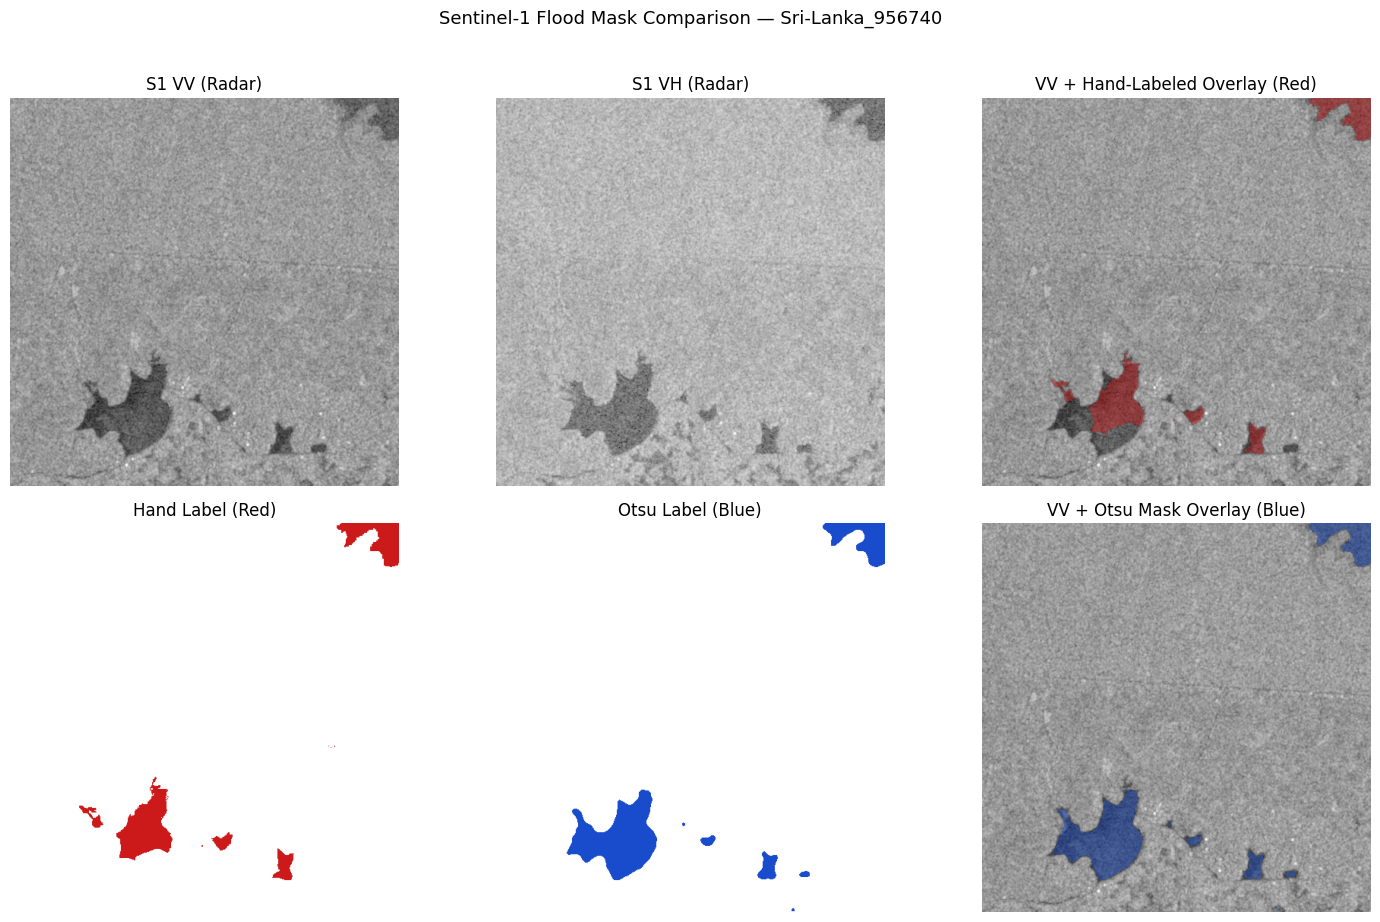

In [ ]:
visualize_S1Hand_and_Otsu_side_by_side(S1_HAND, LAB_HAND, OTS_HAND, auto_flip=True)

An Otsu mask is an automatically generated water map created using Otsu’s thresholding method, a classical computer vision technique that separates foreground (water) and background (land) based on pixel intensity histograms. In the Sen1Floods11 dataset, Otsu masks were derived directly from Sentinel-1 radar backscatter values—typically the VH or VV channels—without any manual labeling. They serve as weak or pseudo-labels, offering a quick, unsupervised way to detect water when human annotations are unavailable.

## S2Hand = Sentinel-2 “optical” imagery that corresponds spatially to each Sentinel-1 tile.

In [ ]:
import rasterio, numpy as np, matplotlib.pyplot as plt, glob, os, random
from matplotlib.colors import ListedColormap

def visualize_S1_and_S2_side_by_side(S1_HAND, S2_HAND, LAB_HAND, auto_flip=False):
    """
    Visualize a Sentinel-1 and Sentinel-2 tile pair with hand-labeled flood mask.

    Parameters
    ----------
    S1_HAND : str
        Path to folder containing Sentinel-1 hand-labeled TIFFs.
    S2_HAND : str
        Path to folder containing Sentinel-2 hand-labeled TIFFs.
    LAB_HAND : str
        Path to folder containing LabelHand TIFFs.
    auto_flip : bool
        Whether to auto-flip constant masks using validate_mask().
    """

    # --- Random tile selection ---
    s1_files = sorted(glob.glob(f"{S1_HAND}/*.tif"))
    s1_path = random.choice(s1_files)
    prefix = os.path.basename(s1_path).replace("_S1Hand.tif", "")
    s2_path = f"{S2_HAND}/{prefix}_S2Hand.tif"
    label_path = f"{LAB_HAND}/{prefix}_LabelHand.tif"

    print(f"\nSelected prefix: {prefix}")
    print(f"S1 file: {os.path.basename(s1_path)}")
    print(f"S2 file: {os.path.basename(s2_path)}")
    print(f"Label:   {os.path.basename(label_path)}")

    # --- Load data ---
    with rasterio.open(s1_path) as src:
        s1 = src.read()  # (2,H,W)
    with rasterio.open(s2_path) as src:
        s2 = src.read()  # typically (10,H,W) or (13,H,W)
    with rasterio.open(label_path) as src:
        raw_mask = src.read(1)

    # --- Clean mask (-1,0,1) ---
    mask = np.nan_to_num(raw_mask)
    mask[mask < 0] = 0
    mask = (mask == 1).astype(np.uint8)

    # --- Validate mask ---
    mask, valid = validate_mask(mask, auto_flip=auto_flip, name=os.path.basename(label_path))
    if not valid:
        print("Skipping visualization (invalid mask).")
        return

    # --- Normalize helper ---
    def norm(a):
        a = np.nan_to_num(a)
        vmin, vmax = np.nanmin(a), np.nanmax(a)
        if vmax - vmin < 1e-6:
            return np.zeros_like(a)
        return (a - vmin) / (vmax - vmin)

    # --- Sentinel-1 normalization ---
    vv, vh = s1[0], s1[1]
    vvn, vhn = norm(vv), norm(vh)

    # --- Sentinel-2 true color (bands 4,3,2 = R,G,B) ---
    if s2.shape[0] >= 4:
        rgb = np.stack([norm(s2[3]), norm(s2[2]), norm(s2[1])], axis=-1)
    else:
        print("⚠️ S2 tile missing RGB bands; skipping visualization.")
        return

    # --- Overlay (red = water only) ---
    overlay = np.zeros((*mask.shape, 4))
    overlay[mask == 1] = [0.8, 0.1, 0.1, 0.45]

    # --- Plot ---
    fig, ax = plt.subplots(2, 3, figsize=(15, 9))
    plt.suptitle(f"Sentinel-1 vs Sentinel-2 Flood Comparison — {prefix}", fontsize=13, y=1.02)

    # Sentinel-1 row
    ax[0,0].imshow(vvn, cmap='gray'); ax[0,0].set_title("S1 VV (Radar)")
    ax[0,1].imshow(vhn, cmap='gray'); ax[0,1].set_title("S1 VH (Radar)")
    ax[0,2].imshow(vvn, cmap='gray')
    ax[0,2].imshow(overlay)
    ax[0,2].set_title("S1 VV + Flood Mask (Red)")

    # Sentinel-2 row
    ax[1,0].imshow(rgb); ax[1,0].set_title("S2 RGB (True Color)")
    ax[1,1].imshow(rgb)
    ax[1,1].imshow(overlay)
    ax[1,1].set_title("S2 RGB + Flood Mask (Red)")
    ax[1,2].axis("off")

    for a in ax.flat: a.axis("off")
    plt.tight_layout()
    plt.show()



Selected prefix: USA_831672
S1 file: USA_831672_S1Hand.tif
S2 file: USA_831672_S2Hand.tif
Label:   USA_831672_LabelHand.tif
✅ [USA_831672_LabelHand.tif] Looks valid — 8.0% water, 92.0% land.


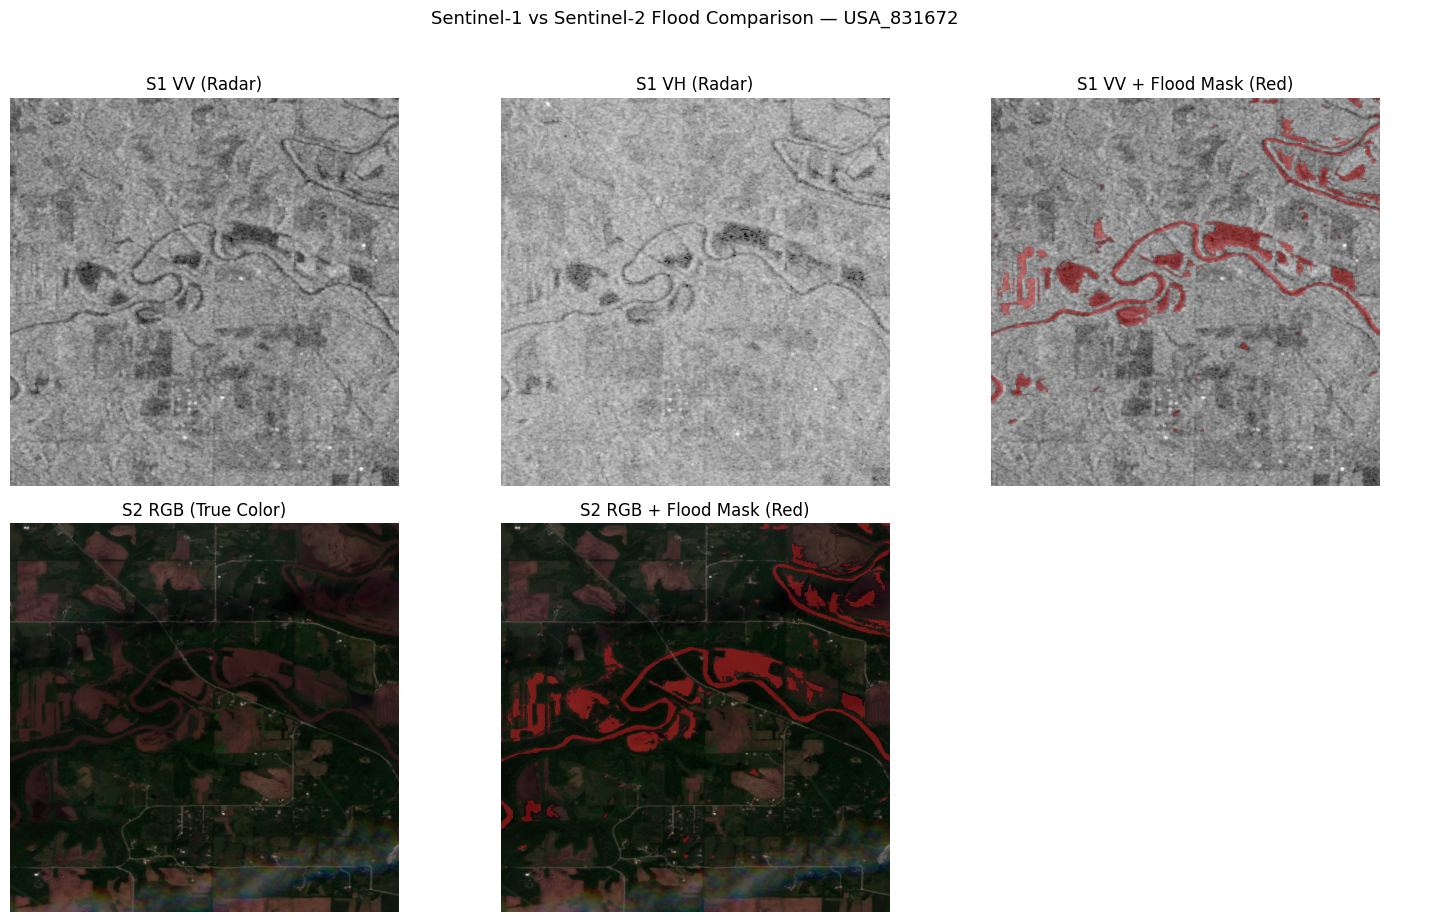

In [ ]:
visualize_S1_and_S2_side_by_side(S1_HAND, S2_HAND, LAB_HAND, auto_flip=True)